In [138]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from pysal.model import mgwr
import pysal.lib
import libpysal as ps
from libpysal.weights.contiguity import Queen
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import palettable.colorbrewer.sequential as pcs
import seaborn as sns
import statsmodels.api as sm      #for regression modelling
from scipy import stats           #for kendal tau
from sklearn import linear_model  #for cross-validation
from sklearn import model_selection
from libpysal import weights
from libpysal import cg as geometry

# Data wrangling

In [139]:
crime= pd.read_csv('LSOA RESIDENTIAL BURGLARIES.csv')

In [140]:
crime.head(5)

,LSOA Code,LSOA Name,Total,Avg
0,E01000471,Brent 026A,3,0.250000
1,E01000472,Brent 029A,10,0.833333
2,E01000473,Brent 029B,11,0.916667
3,E01000474,Brent 026B,4,0.333333
4,E01000475,Brent 029C,6,0.500000


In [141]:
df= crime.rename(columns= {'LSOA Name' : 'LSOA11NM'})

In [142]:
lsoa= gpd.read_file('lsoa')

In [143]:
df.head()

,LSOA Code,LSOA11NM,Total,Avg
0,E01000471,Brent 026A,3,0.250000
1,E01000472,Brent 029A,10,0.833333
2,E01000473,Brent 029B,11,0.916667
3,E01000474,Brent 026B,4,0.333333
4,E01000475,Brent 029C,6,0.500000


<AxesSubplot:>

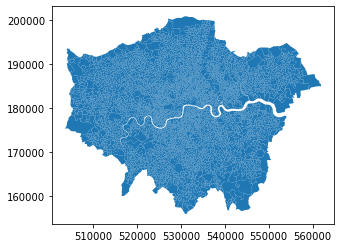

In [144]:
lsoa.plot()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
465,E01000471,Brent 026A,E02000118,Brent 026,E09000005,Brent,E12000007,London,1638,1638,0,117.8,469,3.5,"POLYGON ((518728.138 183645.948, 518850.551 18..."
466,E01000472,Brent 029A,E02000121,Brent 029,E09000005,Brent,E12000007,London,1346,1346,0,31.1,512,2.6,"POLYGON ((518124.000 183710.000, 518069.892 18..."
467,E01000473,Brent 029B,E02000121,Brent 029,E09000005,Brent,E12000007,London,1883,1883,0,108.5,520,3.6,"POLYGON ((518402.056 184434.910, 518283.248 18..."
468,E01000474,Brent 026B,E02000118,Brent 026,E09000005,Brent,E12000007,London,1999,1999,0,101.7,501,4.0,"POLYGON ((518928.906 184521.172, 518913.814 18..."
469,E01000475,Brent 029C,E02000121,Brent 029,E09000005,Brent,E12000007,London,1976,1976,0,63.3,596,3.3,"POLYGON ((518034.791 183756.793, 517959.000 18..."


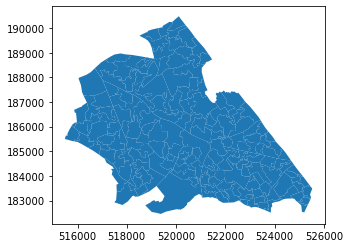

In [145]:
brent= lsoa[lsoa.LAD11NM.str.contains('Brent')]
brent.plot()
brent.head()

In [146]:
brent.reset_index()

,index,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,465,E01000471,Brent 026A,E02000118,Brent 026,E09000005,Brent,E12000007,London,1638,1638,0,117.8,469,3.5,"POLYGON ((518728.138 183645.948, 518850.551 18..."
1,466,E01000472,Brent 029A,E02000121,Brent 029,E09000005,Brent,E12000007,London,1346,1346,0,31.1,512,2.6,"POLYGON ((518124.000 183710.000, 518069.892 18..."
2,467,E01000473,Brent 029B,E02000121,Brent 029,E09000005,Brent,E12000007,London,1883,1883,0,108.5,520,3.6,"POLYGON ((518402.056 184434.910, 518283.248 18..."
3,468,E01000474,Brent 026B,E02000118,Brent 026,E09000005,Brent,E12000007,London,1999,1999,0,101.7,501,4.0,"POLYGON ((518928.906 184521.172, 518913.814 18..."
4,469,E01000475,Brent 029C,E02000121,Brent 029,E09000005,Brent,E12000007,London,1976,1976,0,63.3,596,3.3,"POLYGON ((518034.791 183756.793, 517959.000 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,4741,E01033456,Brent 027F,E02000119,Brent 027,E09000005,Brent,E12000007,London,2208,2200,8,83.4,743,3.0,"POLYGON ((520500.479 184284.760, 520551.414 18..."
169,4742,E01033457,Brent 017G,E02000109,Brent 017,E09000005,Brent,E12000007,London,1712,1700,12,95.1,562,3.0,"POLYGON ((519108.471 186052.681, 518985.497 18..."
170,4743,E01033463,Brent 003G,E02000095,Brent 003,E09000005,Brent,E12000007,London,2939,2805,134,70.2,848,3.3,"POLYGON ((518722.115 188825.125, 518878.195 18..."
171,4744,E01033464,Brent 010F,E02000102,Brent 010,E09000005,Brent,E12000007,London,3022,3018,4,125.3,813,3.7,"POLYGON ((521772.706 186717.882, 521793.000 18..."


In [147]:
data= df.merge(brent, how='left', on='LSOA11NM')

In [148]:
data.head()

,LSOA Code,LSOA11NM,Total,Avg,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000471,Brent 026A,3,0.250000,E01000471,E02000118,Brent 026,E09000005,Brent,E12000007,London,1638,1638,0,117.8,469,3.5,"POLYGON ((518728.138 183645.948, 518850.551 18..."
1,E01000472,Brent 029A,10,0.833333,E01000472,E02000121,Brent 029,E09000005,Brent,E12000007,London,1346,1346,0,31.1,512,2.6,"POLYGON ((518124.000 183710.000, 518069.892 18..."
2,E01000473,Brent 029B,11,0.916667,E01000473,E02000121,Brent 029,E09000005,Brent,E12000007,London,1883,1883,0,108.5,520,3.6,"POLYGON ((518402.056 184434.910, 518283.248 18..."
3,E01000474,Brent 026B,4,0.333333,E01000474,E02000118,Brent 026,E09000005,Brent,E12000007,London,1999,1999,0,101.7,501,4.0,"POLYGON ((518928.906 184521.172, 518913.814 18..."
4,E01000475,Brent 029C,6,0.500000,E01000475,E02000121,Brent 029,E09000005,Brent,E12000007,London,1976,1976,0,63.3,596,3.3,"POLYGON ((518034.791 183756.793, 517959.000 18..."


In [149]:
type(data)

pandas.core.frame.DataFrame

In [150]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(data)

In [151]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

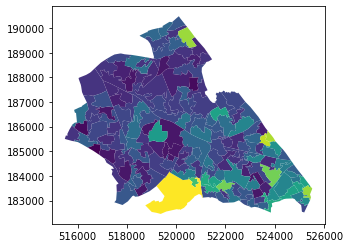

In [343]:
gdf.plot(column='Avg')

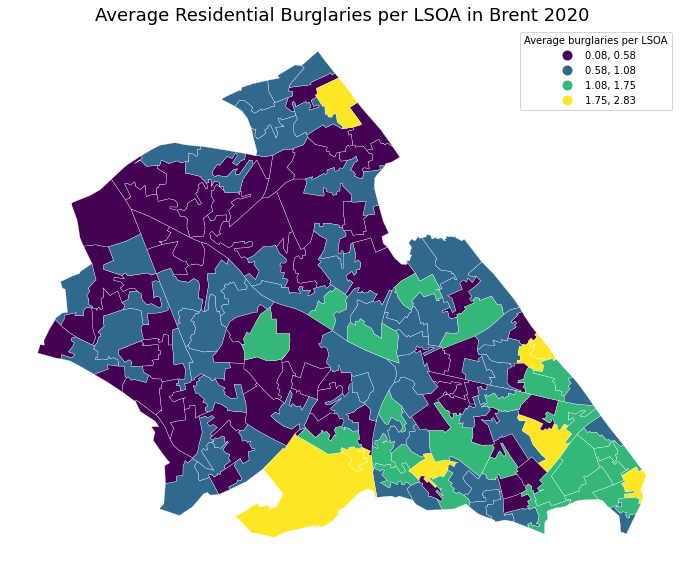

In [348]:
fig, ax1 = plt.subplots(1, figsize=(12,10))
full_data.plot(ax=ax1, 
        column= 'Avg', scheme= 'fisher_jenks', k=4,
        cmap = 'viridis',
        edgecolor='white', linewidth=0.3,
        legend=True, 
                 legend_kwds={'title':'Average burglaries per LSOA'})

ax1.axis('off')
ax1.set_title('Average Residential Burglaries per LSOA in Brent 2020', fontsize=18)
ax1.annotate('data from London Data Store: Recorded crime: Geographic Breakdown https://data.london.gov.uk/dataset/recorded_crime_summary', (5,0), fontsize=10)
plt.show()

In [158]:
iv= pd.read_csv('independant variables.csv')

In [159]:
iv.head()

,LSOA11NM,IMDscore,Employmentscore,BHSscore,Crimescore,ESTscore,MedianIncome,AVHHOLDSZ,RoadsArea,POPDEN,Houseprice
0,Brent 026A,21.5,0.1,49.8,-0.3,22.6,32850.0,3.5,14630.6345,117.8,413886.0
1,Brent 029A,22.9,0.1,48.0,0.0,12.3,33460.0,2.6,232884.0670,31.1,312544.0
2,Brent 029B,25.2,0.1,46.3,0.2,27.0,30790.0,3.6,140182.0270,108.5,326614.0
3,Brent 026B,21.8,0.1,47.0,-0.5,28.3,31090.0,4.0,35633.1673,101.7,446536.0
4,Brent 029C,21.1,0.1,53.3,-0.5,13.3,32700.0,3.3,269030.4870,63.3,393850.0


In [160]:
full_data= gdf.merge(iv, how='left', on='LSOA11NM')

In [161]:
full_data.head()

,LSOA Code,LSOA11NM,Total,Avg,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,...,IMDscore,Employmentscore,BHSscore,Crimescore,ESTscore,MedianIncome,AVHHOLDSZ_y,RoadsArea,POPDEN_y,Houseprice
0,E01000471,Brent 026A,3,0.250000,E01000471,E02000118,Brent 026,E09000005,Brent,E12000007,...,21.5,0.1,49.8,-0.3,22.6,32850.0,3.5,14630.6345,117.8,413886.0
1,E01000472,Brent 029A,10,0.833333,E01000472,E02000121,Brent 029,E09000005,Brent,E12000007,...,22.9,0.1,48.0,0.0,12.3,33460.0,2.6,232884.0670,31.1,312544.0
2,E01000473,Brent 029B,11,0.916667,E01000473,E02000121,Brent 029,E09000005,Brent,E12000007,...,25.2,0.1,46.3,0.2,27.0,30790.0,3.6,140182.0270,108.5,326614.0
3,E01000474,Brent 026B,4,0.333333,E01000474,E02000118,Brent 026,E09000005,Brent,E12000007,...,21.8,0.1,47.0,-0.5,28.3,31090.0,4.0,35633.1673,101.7,446536.0
4,E01000475,Brent 029C,6,0.500000,E01000475,E02000121,Brent 029,E09000005,Brent,E12000007,...,21.1,0.1,53.3,-0.5,13.3,32700.0,3.3,269030.4870,63.3,393850.0


In [163]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'Total', 'Avg', 'LSOA11CD', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN_x', 'HHOLDS', 'AVHHOLDSZ_x',
       'geometry', 'IMDscore', 'Employmentscore', 'BHSscore', 'Crimescore',
       'ESTscore', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'POPDEN_y',
       'Houseprice'],
      dtype='object')

#  Standardising dependant variable for further analysis:

<AxesSubplot:>

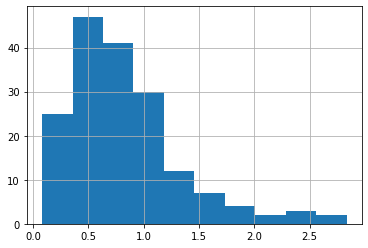

In [334]:
full_data['Avg'].hist()

In [164]:
full_data['SAvg']= np.log(full_data['Avg'])

<AxesSubplot:>

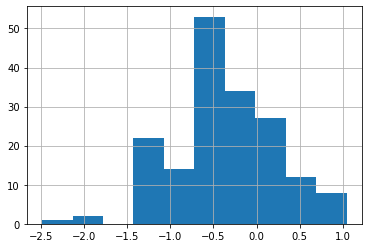

In [165]:
full_data['SAvg'].hist()

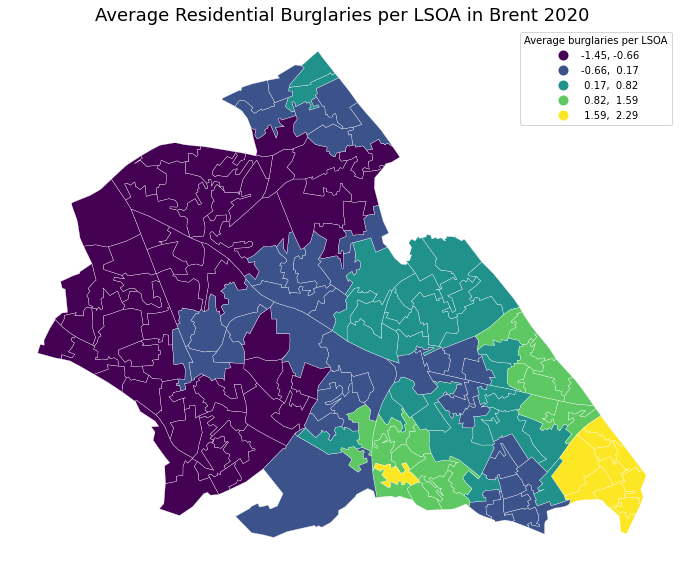

In [436]:
fig, ax1 = plt.subplots(1, figsize=(12,10))
full_data.plot(ax=ax1, 
        column= 'SAvg', scheme= 'fisher_jenks', k=5,
        cmap = 'viridis',
        edgecolor='white', linewidth=0.3,
        legend=True, 
                 legend_kwds={'title':'Average burglaries per LSOA'})

ax1.axis('off')
ax1.set_title('Average Residential Burglaries per LSOA in Brent 2020', fontsize=18)
ax1.annotate('London Data Store: Recorded crime: Geographic Breakdown', (10,0), fontsize=10)
plt.show()
fig.savefig('AvgResBurg.png', dpi=300, bbox_inches='tight')

In [166]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'Total', 'Avg', 'LSOA11CD', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN_x', 'HHOLDS', 'AVHHOLDSZ_x',
       'geometry', 'IMDscore', 'Employmentscore', 'BHSscore', 'Crimescore',
       'ESTscore', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'POPDEN_y',
       'Houseprice', 'SAvg'],
      dtype='object')

# OLS 

In [167]:
full_data.count()

LSOA Code          173
LSOA11NM           173
Total              173
Avg                173
LSOA11CD           173
MSOA11CD           173
MSOA11NM           173
LAD11CD            173
LAD11NM            173
RGN11CD            173
RGN11NM            173
USUALRES           173
HHOLDRES           173
COMESTRES          173
POPDEN_x           173
HHOLDS             173
AVHHOLDSZ_x        173
geometry           173
IMDscore           173
Employmentscore    173
BHSscore           173
Crimescore         173
ESTscore           173
MedianIncome       173
AVHHOLDSZ_y        173
RoadsArea          173
POPDEN_y           173
Houseprice         173
SAvg               173
dtype: int64

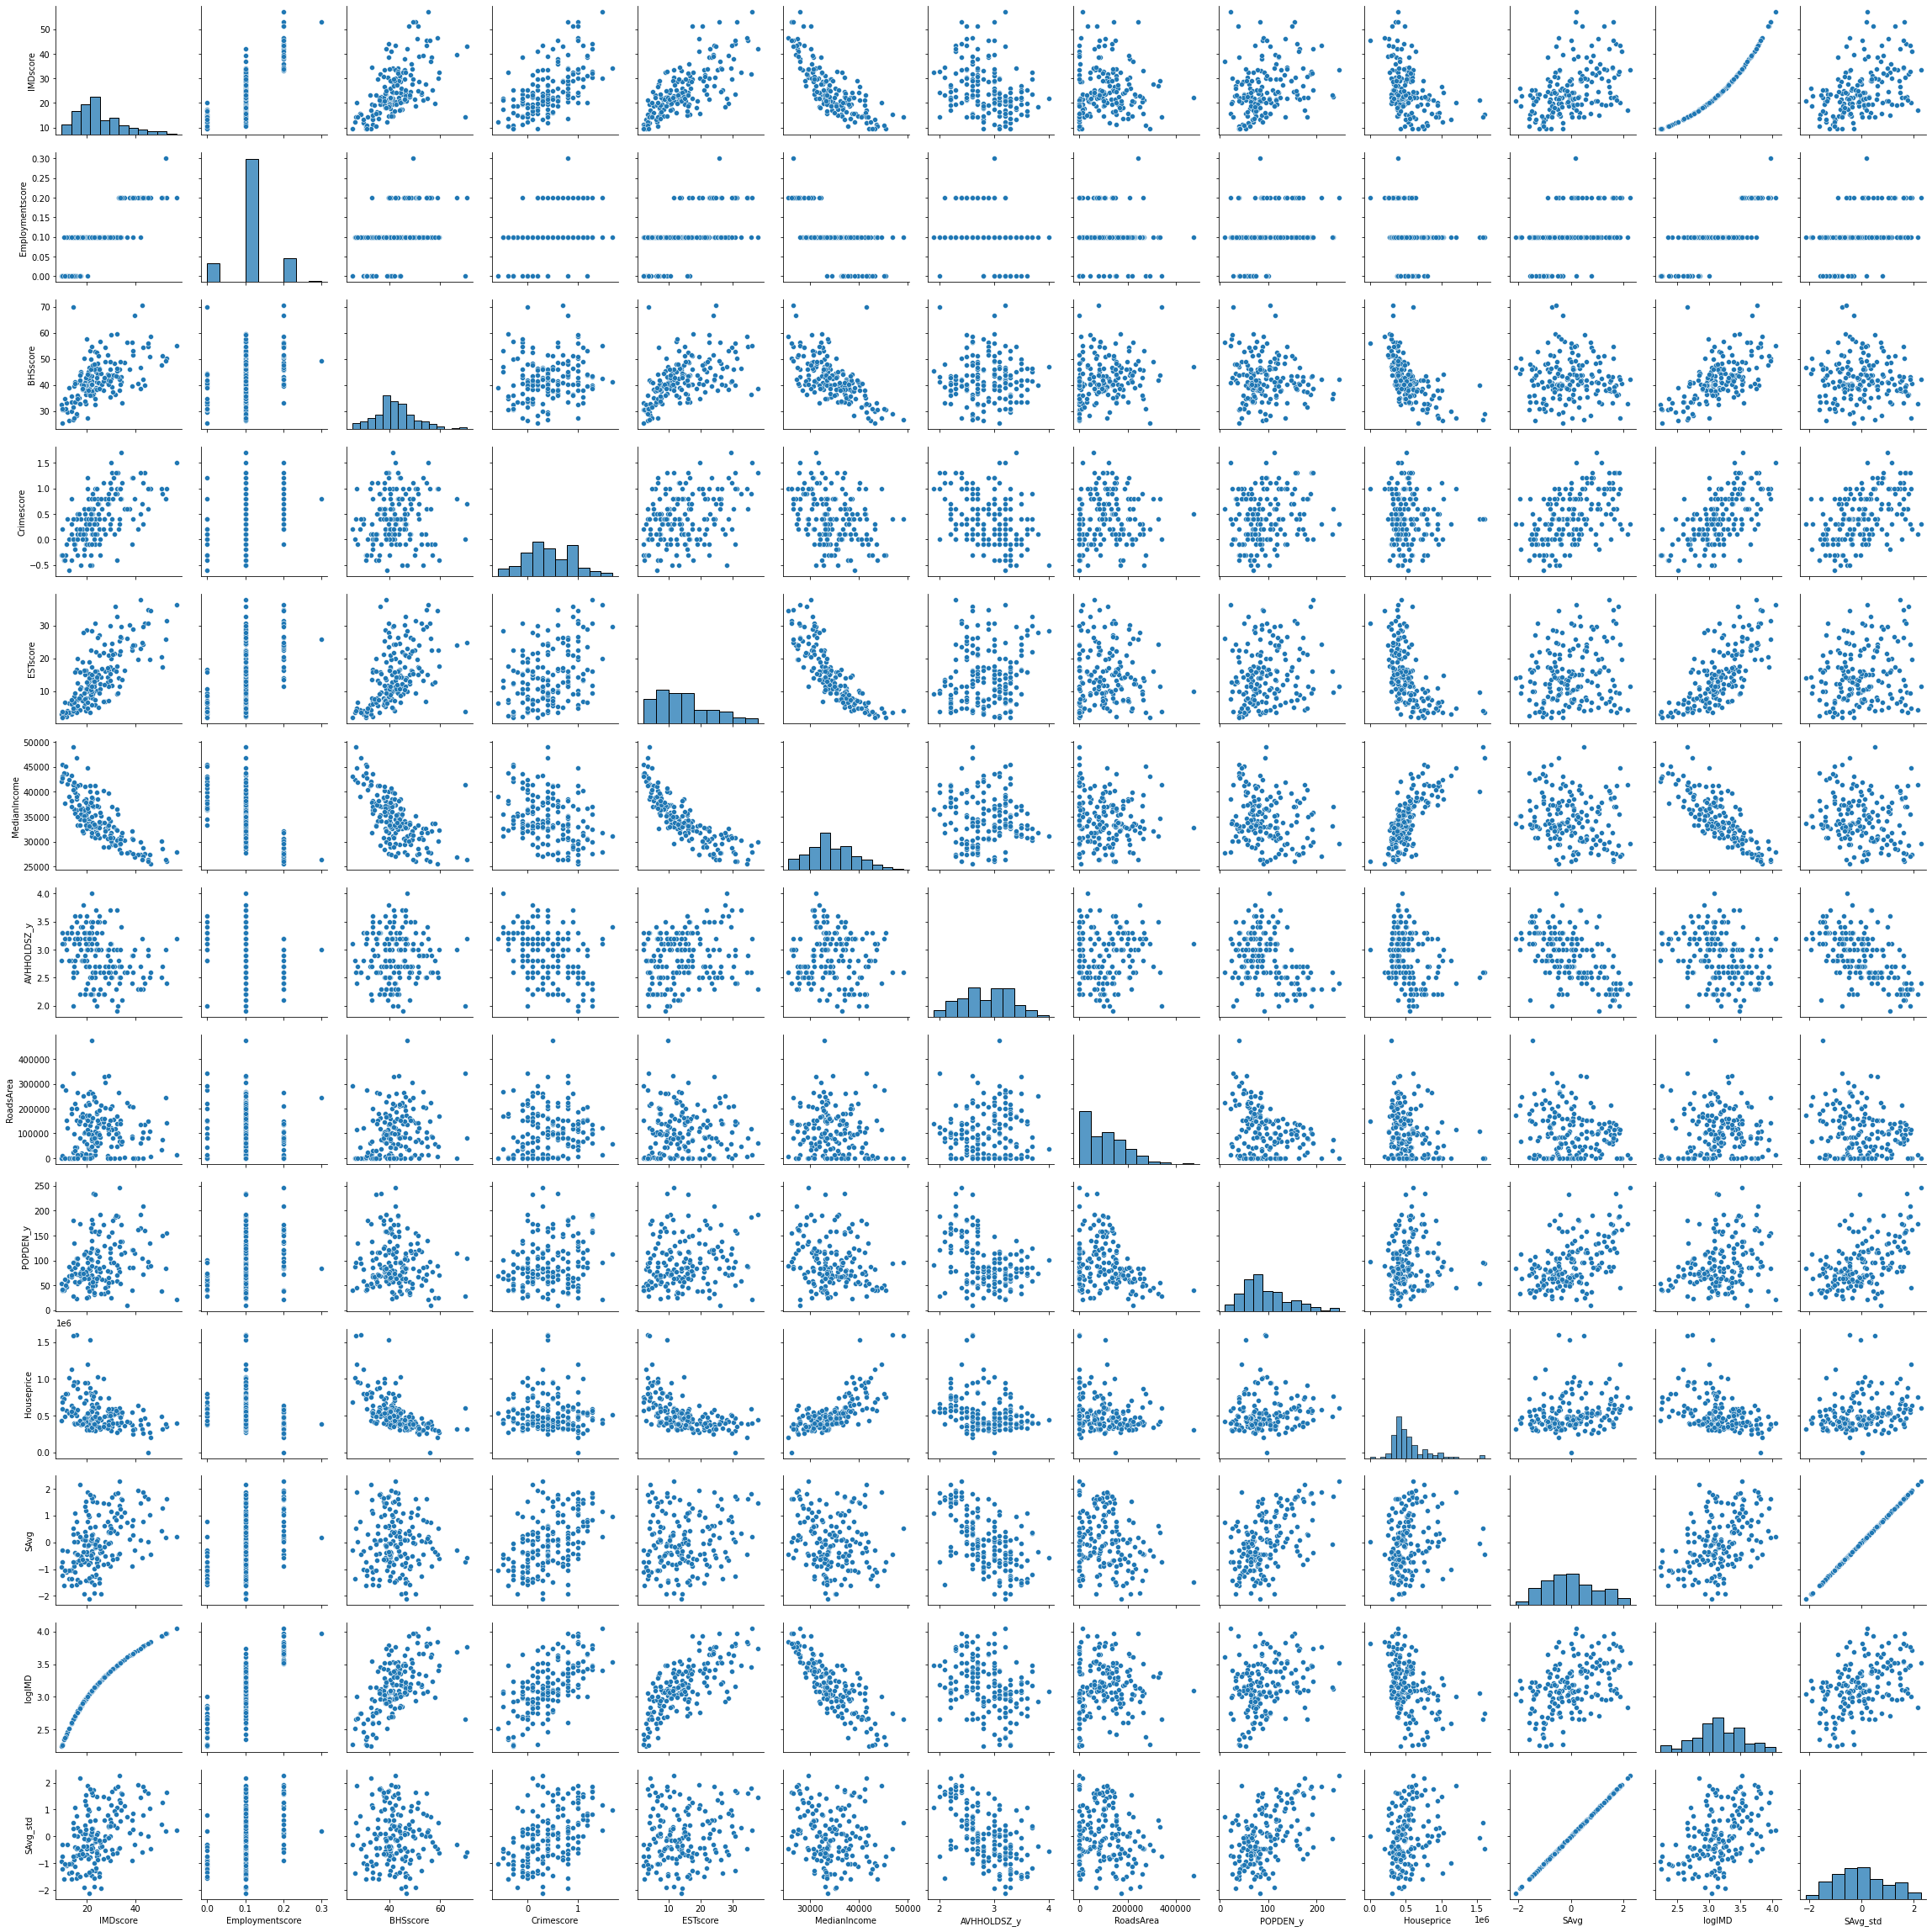

In [228]:
sns.pairplot(full_data.iloc[:, 18:32])

In [230]:
full_data['logIMD'] = np.log(full_data['IMDscore'])
df_X = full_data['logIMD']
df_y = full_data['SAvg']     

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)

mod_dlc = sm.OLS.from_formula("SAvg ~ logIMD", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

-3.696406971796592
[1.17208713]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     43.91
Date:                Wed, 12 Jan 2022   Prob (F-statistic):           4.30e-10
Time:                        23:49:59   Log-Likelihood:                -225.21
No. Observations:                 173   AIC:                             454.4
Df Residuals:                     171   BIC:                             460.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.696

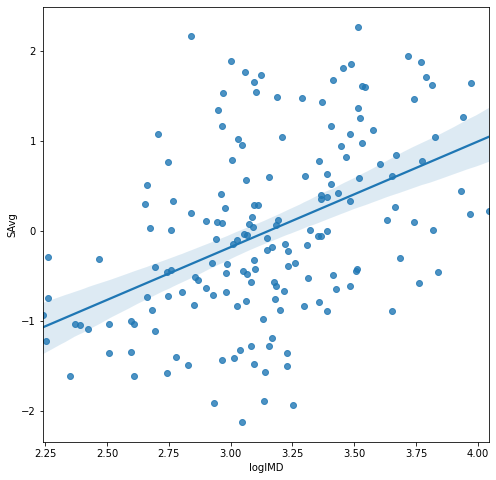

In [231]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logIMD, y=full_data.SAvg) 
fig.savefig('IMD.png', dbi=300, bbox_inches='tight', facecolor='white')

In [232]:
df_X = full_data['Crimescore']
df_y = full_data['SAvg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ Crimescore", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())


-0.42764923798052684
[1.01625437]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     53.35
Date:                Wed, 12 Jan 2022   Prob (F-statistic):           1.01e-11
Time:                        23:49:59   Log-Likelihood:                -221.49
No. Observations:                 173   AIC:                             447.0
Df Residuals:                     171   BIC:                             453.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4

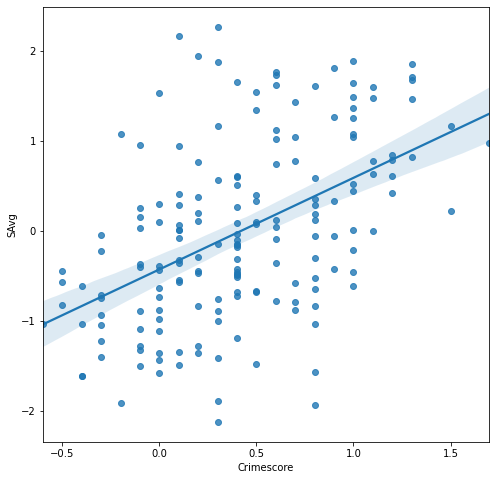

In [233]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.Crimescore, y=full_data.SAvg) 
fig.savefig('Crimescore.png', dbi=300, bbox_inches='tight', facecolor='white')

In [234]:
df_X = (full_data['AVHHOLDSZ_y'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ AVHHOLDSZ_y", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

3.668445184136954
[-1.28003432]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     75.62
Date:                Wed, 12 Jan 2022   Prob (F-statistic):           2.74e-15
Time:                        23:49:59   Log-Likelihood:                -213.30
No. Observations:                 173   AIC:                             430.6
Df Residuals:                     171   BIC:                             436.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.

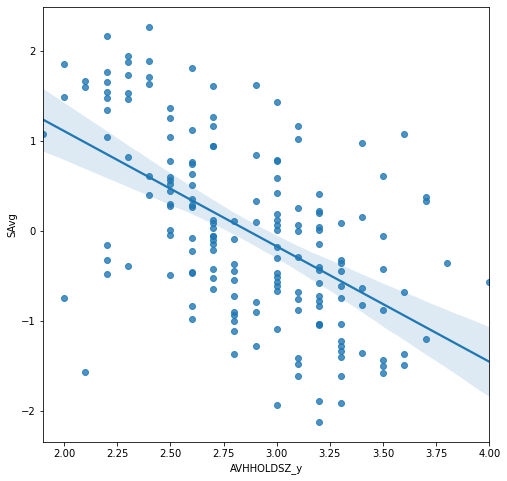

In [235]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.AVHHOLDSZ_y, y=full_data.SAvg) 
fig.savefig('AVHH.png', dbi=300, bbox_inches='tight', facecolor='white')

In [358]:
df_X = (full_data['POPDEN_x'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ POPDEN_x", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

-1.1180260557372592
[0.0118103]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     77.09
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.64e-15
Time:                        19:02:51   Log-Likelihood:                -212.78
No. Observations:                 173   AIC:                             429.6
Df Residuals:                     171   BIC:                             435.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.118

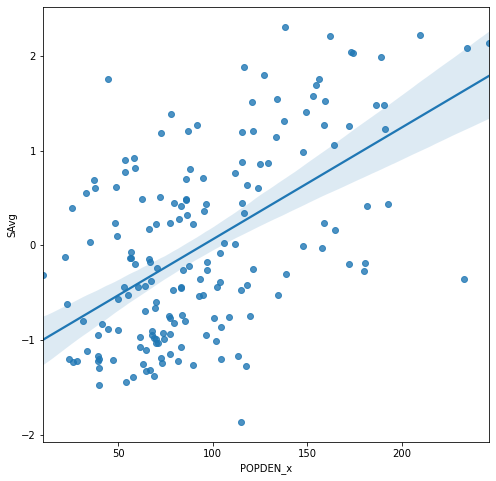

In [359]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.POPDEN_x, y=full_data.SAvg) 
fig.savefig('POPDEN.png', dbi=300, bbox_inches='tight', facecolor='white')

In [355]:
df_X = (full_data['Employmentscore'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ Employmentscore", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

-0.8376886811546572
[8.00663767]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     36.91
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           7.80e-09
Time:                        19:01:15   Log-Likelihood:                -228.07
No. Observations:                 173   AIC:                             460.1
Df Residuals:                     171   BIC:                             466.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept

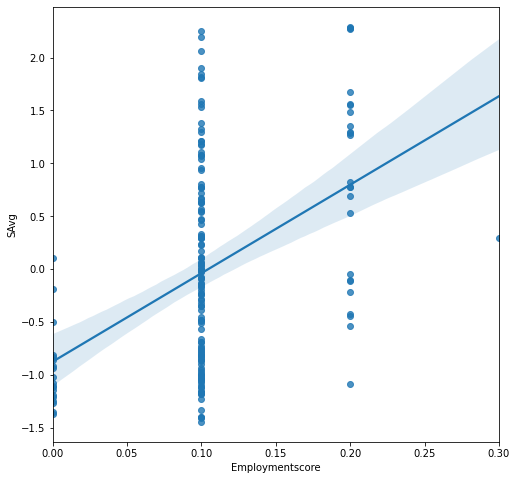

In [434]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.Employmentscore, y=full_data.SAvg) 

In [356]:
df_X = (full_data['BHSscore'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ BHSscore", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

0.5812751847210474
[-0.013711]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.104
Date:                Thu, 13 Jan 2022   Prob (F-statistic):              0.149
Time:                        19:01:39   Log-Likelihood:                -243.92
No. Observations:                 173   AIC:                             491.8
Df Residuals:                     171   BIC:                             498.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5813

In [368]:
df_X = (full_data['ESTscore'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ ESTscore", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

-0.2998567198672393
[0.0202598]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     5.314
Date:                Thu, 13 Jan 2022   Prob (F-statistic):             0.0224
Time:                        19:05:25   Log-Likelihood:                -242.33
No. Observations:                 173   AIC:                             488.7
Df Residuals:                     171   BIC:                             495.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.299

In [369]:
df_X = (full_data['MedianIncome'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ MedianIncome", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

1.354094286796514
[-3.92493728e-05]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.124
Date:                Thu, 13 Jan 2022   Prob (F-statistic):             0.0143
Time:                        19:05:49   Log-Likelihood:                -241.93
No. Observations:                 173   AIC:                             487.9
Df Residuals:                     171   BIC:                             494.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept   

In [370]:
df_X = (full_data['RoadsArea'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ RoadsArea", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

0.23198335331406625
[-2.17150784e-06]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.813
Date:                Thu, 13 Jan 2022   Prob (F-statistic):            0.00985
Time:                        19:06:06   Log-Likelihood:                -241.60
No. Observations:                 173   AIC:                             487.2
Df Residuals:                     171   BIC:                             493.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

In [432]:
df_X = (full_data['Houseprice'])
df_y = full_data['SAvg']                 

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

print(mod_dlc.intercept_)
print(mod_dlc.coef_)


mod_dlc = sm.OLS.from_formula("SAvg ~ Houseprice", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

-0.5611933328336849
[1.05838351e-06]
                            OLS Regression Results                            
Dep. Variable:                   SAvg   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     11.59
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           0.000827
Time:                        19:27:51   Log-Likelihood:                -239.30
No. Observations:                 173   AIC:                             482.6
Df Residuals:                     171   BIC:                             488.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -

In [354]:
# Kendall Tau correlation

In [236]:
mod_dlc_RR_pred= mod_dlc_RR.predict()
stats.kendalltau(full_data['SAvg'], mod_dlc_RR_pred)

KendalltauResult(correlation=0.4087946088730543, pvalue=9.187261205753364e-15)

In [237]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'Total', 'Avg', 'LSOA11CD', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN_x', 'HHOLDS', 'AVHHOLDSZ_x',
       'geometry', 'IMDscore', 'Employmentscore', 'BHSscore', 'Crimescore',
       'ESTscore', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'POPDEN_y',
       'Houseprice', 'SAvg', 'logIMD', 'SAvg_std'],
      dtype='object')

In [371]:
df_X = full_data[['Crimescore','AVHHOLDSZ_y', 'logIMD','POPDEN_x']]  
df_y = full_data['SAvg']                  

#fit the mode 
mod_dlc_dbh = linear_model.LinearRegression()
mod_dlc_dbh.fit(df_X, df_y)

#we can get simple otuputs
print(mod_dlc_dbh.coef_)  #model coefficients
print(mod_dlc_dbh.score(df_X, df_y)) #r2

[ 0.6188883  -0.76479183  0.28043761  0.00709449]
0.59916726776217


In [372]:
Avg = full_data['SAvg']

y = np.array(Avg)

y.shape = (len(Avg),1)

In [373]:
X = []
X.append(full_data['Crimescore'])
X.append(full_data['AVHHOLDSZ_y'])
X.append(full_data['logIMD'])
X.append(full_data['POPDEN_x'])

X=np.array(X).T

In [374]:
print(X.shape)

(173, 4)


In [375]:
ols = pysal.model.spreg.OLS(y, X, name_y=['SAvg'], name_x=['Crimescore','AVHHOLDSZ_y','logIMD','POPDEN_x'], name_ds=['full_data'], white_test=True)
print(ols.summary) 

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :['full_data']
Weights matrix      :        None
Dependent Variable  :    ['SAvg']                Number of Observations:         173
Mean dependent var  :      0.0000                Number of Variables   :           5
S.D. dependent var  :      1.0000                Degrees of Freedom    :         168
R-squared           :      0.5992
Adjusted R-squared  :      0.5896
Sum squared residual:      68.943                F-statistic           :     62.7819
Sigma-square        :       0.410                Prob(F-statistic)     :   2.287e-32
S.E. of regression  :       0.641                Log likelihood        :    -165.896
Sigma-square ML     :       0.399                Akaike info criterion :     341.791
S.E of regression ML:      0.6313                Schwarz criterion     :     357.558

----------------------------------------------------------------------------

In [376]:
full_data.head()

,LSOA Code,LSOA11NM,Total,Avg,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,...,AVHHOLDSZ_y,RoadsArea,POPDEN_y,Houseprice,SAvg,logIMD,SAvg_std,Centre,X,Y
0,E01000471,Brent 026A,3,0.250000,E01000471,E02000118,Brent 026,E09000005,Brent,E12000007,...,3.5,14630.6345,117.8,413886.0,-1.278151,3.068053,-1.278151,POINT (518589.839 183419.749),518589.838708,183419.748518
1,E01000472,Brent 029A,10,0.833333,E01000472,E02000121,Brent 029,E09000005,Brent,E12000007,...,2.6,232884.0670,31.1,312544.0,-0.796728,3.131137,-0.796728,POINT (517940.361 183234.986),517940.361237,183234.986125
2,E01000473,Brent 029B,11,0.916667,E01000473,E02000121,Brent 029,E09000005,Brent,E12000007,...,3.6,140182.0270,108.5,326614.0,-0.758394,3.226844,-0.758394,POINT (518287.225 184038.829),518287.224933,184038.829376
3,E01000474,Brent 026B,4,0.333333,E01000474,E02000118,Brent 026,E09000005,Brent,E12000007,...,4.0,35633.1673,101.7,446536.0,-1.012764,3.081910,-1.012764,POINT (518592.614 184423.015),518592.613930,184423.015133
4,E01000475,Brent 029C,6,0.500000,E01000475,E02000121,Brent 029,E09000005,Brent,E12000007,...,3.3,269030.4870,63.3,393850.0,-1.249795,3.049273,-1.249795,POINT (517614.983 183935.785),517614.983279,183935.784684


In [377]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'Total', 'Avg', 'LSOA11CD', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN_x', 'HHOLDS', 'AVHHOLDSZ_x',
       'geometry', 'IMDscore', 'Employmentscore', 'BHSscore', 'Crimescore',
       'ESTscore', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'POPDEN_y',
       'Houseprice', 'SAvg', 'logIMD', 'SAvg_std', 'Centre', 'X', 'Y'],
      dtype='object')

In [379]:
data= full_data.drop(['LSOA Code', 'LSOA11NM', 'Total', 'LSOA11CD', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'HHOLDS', 'AVHHOLDSZ_x',
       'geometry', 'IMDscore', 'Employmentscore', 'BHSscore',
       'ESTscore', 'MedianIncome', 'RoadsArea', 'POPDEN_y',
       'Houseprice'], axis=1)

# Create a correlation matrix here using pandas
corr= data.corr()

# style it
corr.style.background_gradient(cmap='coolwarm')

,Avg,POPDEN_x,Crimescore,AVHHOLDSZ_y,SAvg,logIMD,SAvg_std,X,Y
Avg,1.000000,0.245972,0.361264,-0.427588,0.638208,0.348122,0.638208,0.426565,-0.271636
POPDEN_x,0.245972,1.000000,0.186454,-0.405695,0.557447,0.305039,0.557447,0.541342,-0.494137
Crimescore,0.361264,0.186454,1.000000,-0.337411,0.539074,0.629023,0.539074,0.415681,-0.261022
AVHHOLDSZ_y,-0.427588,-0.405695,-0.337411,1.000000,-0.600003,-0.306041,-0.600003,-0.624109,0.411179
SAvg,0.638208,0.557447,0.539074,-0.600003,1.000000,0.498353,1.000000,0.779371,-0.417687
logIMD,0.348122,0.305039,0.629023,-0.306041,0.498353,1.000000,0.498353,0.327672,-0.387913
SAvg_std,0.638208,0.557447,0.539074,-0.600003,1.000000,0.498353,1.000000,0.779371,-0.417687
X,0.426565,0.541342,0.415681,-0.624109,0.779371,0.327672,0.779371,1.000000,-0.455491
Y,-0.271636,-0.494137,-0.261022,0.411179,-0.417687,-0.387913,-0.417687,-0.455491,1.000000


In [380]:
y, X = dmatrices('SAvg ~ Crimescore+AVHHOLDSZ_y+logIMD+POPDEN_x', data=full_data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,181.594165,Intercept
1,1.732113,Crimescore
2,1.310400,AVHHOLDSZ_y
3,1.764146,logIMD
4,1.259382,POPDEN_x


# Moran's I

In [381]:
w = weights.distance.KNN.from_dataframe(full_data, k=5)
w.transform = 'R'

In [382]:
full_data['SAvg'] = weights.spatial_lag.lag_spatial(w, full_data['SAvg'])

In [383]:
full_data['SAvg'] = ( full_data['SAvg'] - full_data['SAvg'].mean() )\
                    / full_data['SAvg'].std()
full_data['SAvg_std'] = ( full_data['SAvg'] - full_data['SAvg'].mean() )\
                    / full_data['SAvg'].std()

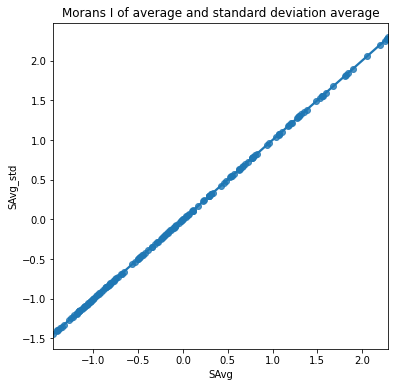

In [384]:
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(x='SAvg', y='SAvg_std', data=full_data, ci=None)
# Display
plt.title('Morans I of average and standard deviation average')
plt.show()

In [385]:
from esda.moran import Moran 
from pysal.explore import esda

In [386]:
avgmoran = esda.moran.Moran(full_data['Avg'], brentKNN5, two_tailed= False )

In [387]:
Stavgmoran = esda.moran.Moran(full_data['SAvg'], brentKNN5, two_tailed= False )

In [388]:
avgmoran.I

0.270167826633126

In [389]:
Stavgmoran.I

0.9415899819365187

In [390]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'Total', 'Avg', 'LSOA11CD', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES',
       'HHOLDRES', 'COMESTRES', 'POPDEN_x', 'HHOLDS', 'AVHHOLDSZ_x',
       'geometry', 'IMDscore', 'Employmentscore', 'BHSscore', 'Crimescore',
       'ESTscore', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'POPDEN_y',
       'Houseprice', 'SAvg', 'logIMD', 'SAvg_std', 'Centre', 'X', 'Y'],
      dtype='object')

# GWR

In [391]:
full_data['Centre']= full_data['geometry'].centroid
full_data.head()

,LSOA Code,LSOA11NM,Total,Avg,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,...,AVHHOLDSZ_y,RoadsArea,POPDEN_y,Houseprice,SAvg,logIMD,SAvg_std,Centre,X,Y
0,E01000471,Brent 026A,3,0.250000,E01000471,E02000118,Brent 026,E09000005,Brent,E12000007,...,3.5,14630.6345,117.8,413886.0,-0.932291,3.068053,-0.932291,POINT (518589.839 183419.749),518589.838708,183419.748518
1,E01000472,Brent 029A,10,0.833333,E01000472,E02000121,Brent 029,E09000005,Brent,E12000007,...,2.6,232884.0670,31.1,312544.0,-1.159067,3.131137,-1.159067,POINT (517940.361 183234.986),517940.361237,183234.986125
2,E01000473,Brent 029B,11,0.916667,E01000473,E02000121,Brent 029,E09000005,Brent,E12000007,...,3.6,140182.0270,108.5,326614.0,-1.161940,3.226844,-1.161940,POINT (518287.225 184038.829),518287.224933,184038.829376
3,E01000474,Brent 026B,4,0.333333,E01000474,E02000118,Brent 026,E09000005,Brent,E12000007,...,4.0,35633.1673,101.7,446536.0,-0.755340,3.081910,-0.755340,POINT (518592.614 184423.015),518592.613930,184423.015133
4,E01000475,Brent 029C,6,0.500000,E01000475,E02000121,Brent 029,E09000005,Brent,E12000007,...,3.3,269030.4870,63.3,393850.0,-0.998830,3.049273,-0.998830,POINT (517614.983 183935.785),517614.983279,183935.784684


In [392]:
full_data['X']=full_data.Centre.map(lambda p: p.x)
full_data['Y']=full_data.Centre.map(lambda p: p.y)
full_data.head()

,LSOA Code,LSOA11NM,Total,Avg,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,...,AVHHOLDSZ_y,RoadsArea,POPDEN_y,Houseprice,SAvg,logIMD,SAvg_std,Centre,X,Y
0,E01000471,Brent 026A,3,0.250000,E01000471,E02000118,Brent 026,E09000005,Brent,E12000007,...,3.5,14630.6345,117.8,413886.0,-0.932291,3.068053,-0.932291,POINT (518589.839 183419.749),518589.838708,183419.748518
1,E01000472,Brent 029A,10,0.833333,E01000472,E02000121,Brent 029,E09000005,Brent,E12000007,...,2.6,232884.0670,31.1,312544.0,-1.159067,3.131137,-1.159067,POINT (517940.361 183234.986),517940.361237,183234.986125
2,E01000473,Brent 029B,11,0.916667,E01000473,E02000121,Brent 029,E09000005,Brent,E12000007,...,3.6,140182.0270,108.5,326614.0,-1.161940,3.226844,-1.161940,POINT (518287.225 184038.829),518287.224933,184038.829376
3,E01000474,Brent 026B,4,0.333333,E01000474,E02000118,Brent 026,E09000005,Brent,E12000007,...,4.0,35633.1673,101.7,446536.0,-0.755340,3.081910,-0.755340,POINT (518592.614 184423.015),518592.613930,184423.015133
4,E01000475,Brent 029C,6,0.500000,E01000475,E02000121,Brent 029,E09000005,Brent,E12000007,...,3.3,269030.4870,63.3,393850.0,-0.998830,3.049273,-0.998830,POINT (517614.983 183935.785),517614.983279,183935.784684


In [393]:
g_y = full_data['SAvg'].values.reshape((-1,1))
g_X = full_data[['Crimescore','AVHHOLDSZ_y','logIMD','POPDEN_x']].values
u = full_data['X']
v = full_data['Y']
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [394]:
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Independent variable
                  g_X, # Dependent variable
                  fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
                  spherical=True) # Spherical coordinates (long-lat) or projected coordinates

In [395]:
bw.search()

172.0

In [396]:
lsoashp= gpd.read_file('lsoa/LSOA_2011_London_gen_MHW.shp')
lsoashp.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [397]:
brent= lsoa[lsoa.LSOA11NM.str.contains('Brent')]
brent.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
465,E01000471,Brent 026A,E02000118,Brent 026,E09000005,Brent,E12000007,London,1638,1638,0,117.8,469,3.5,"POLYGON ((518728.138 183645.948, 518850.551 18..."
466,E01000472,Brent 029A,E02000121,Brent 029,E09000005,Brent,E12000007,London,1346,1346,0,31.1,512,2.6,"POLYGON ((518124.000 183710.000, 518069.892 18..."
467,E01000473,Brent 029B,E02000121,Brent 029,E09000005,Brent,E12000007,London,1883,1883,0,108.5,520,3.6,"POLYGON ((518402.056 184434.910, 518283.248 18..."
468,E01000474,Brent 026B,E02000118,Brent 026,E09000005,Brent,E12000007,London,1999,1999,0,101.7,501,4.0,"POLYGON ((518928.906 184521.172, 518913.814 18..."
469,E01000475,Brent 029C,E02000121,Brent 029,E09000005,Brent,E12000007,London,1976,1976,0,63.3,596,3.3,"POLYGON ((518034.791 183756.793, 517959.000 18..."


<AxesSubplot:>

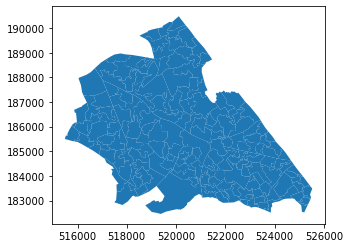

In [398]:
brent.plot()

<AxesSubplot:>

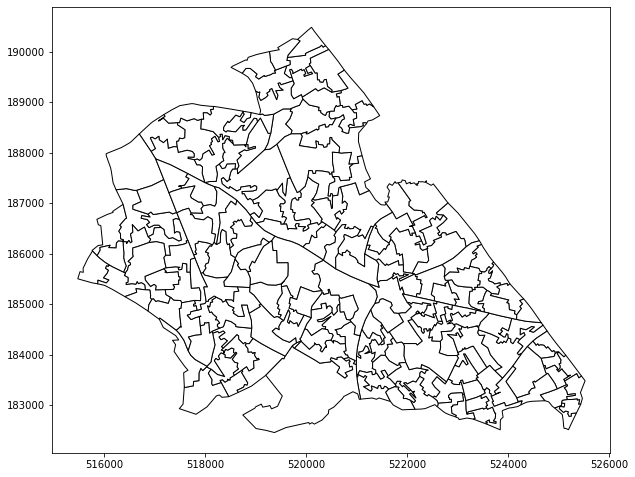

In [399]:
fig, ax = plt.subplots(figsize=(10,10))
brent.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})

In [400]:
brent.crs

<Projected CRS: PROJCS["OSGB 1936 / British National Grid",GEOGCS[ ...>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

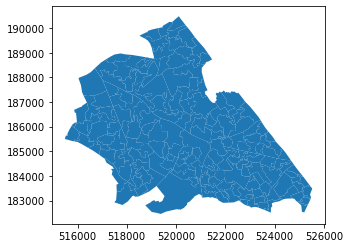

In [401]:
brent = brent.to_crs("EPSG:27700")
brent.plot()

In [402]:
brent.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

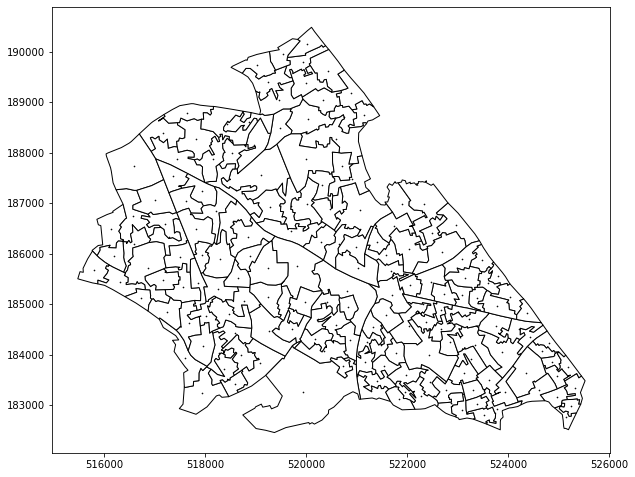

In [403]:
fig, ax = plt.subplots(figsize=(10,10))
brent.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})

brent.centroid.plot(ax=ax, c='black', markersize=0.4)
plt.show()

In [404]:
brentKNN5= weights.distance.KNN.from_dataframe(brent, k=5, ids=brent['LSOA11NM'].tolist())

In [405]:
brentKNN5mat= pd.DataFrame(*brentKNN5.full()).astype(int)
brentKNN5mat.columns=list(brentKNN5mat.index)
brentKNN5mat

,Brent 026A,Brent 029A,Brent 029B,Brent 026B,Brent 029C,Brent 026C,Brent 026D,Brent 029D,Brent 009A,Brent 006A,...,Brent 022D,Brent 024D,Brent 022E,Brent 017F,Brent 031G,Brent 027F,Brent 017G,Brent 003G,Brent 010F,Brent 031H
Brent 026A,0,1,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent 029A,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent 029B,0,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent 026B,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent 029C,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Brent 027F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent 017G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Brent 003G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent 010F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


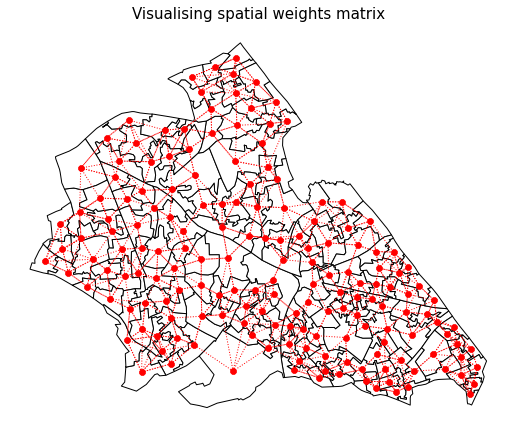

In [406]:
f, ax = plt.subplots(1, figsize=(9,9))
brent.plot(ax=ax, edgecolor='k', facecolor='w')
brentKNN5.plot(brent, indexed_on= 'LSOA11NM', ax=ax, 
               edge_kws=dict(color='r', linestyle=':', 
                             linewidth=1), 
               node_kws=dict(color='r', marker='8'))
ax.axis('off')
ax.set_title('Visualising spatial weights matrix', fontsize=15)
plt.show()

In [407]:
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

In [421]:
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 173
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             63.781
Log-likelihood:                                                    -159.164
AIC:                                                                328.328
AICc:                                                               330.834
BIC:                                                               -801.972
R2:                                                                   0.631
Adj. R2:                                                              0.623

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [422]:
print(results.params.shape)
type(results.params)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

(173, 5)


In [423]:
type(results.params)

numpy.ndarray

In [424]:
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [425]:
df1=pd.DataFrame(full_data["LSOA11NM"])
df2 = df1.assign(intercept=data_params[0],
                 Crimescore=data_params[1],
                 logIMD=data_params[2],
                 AVHHOLDSZ_y=data_params[3],
                 POPDEN_x=data_params[4],
                 localR2=data_localR2[0])
df2.columns
df2

,LSOA11NM,intercept,Crimescore,logIMD,AVHHOLDSZ_y,POPDEN_x,localR2
0,Brent 026A,-3.375864,4.165519,-5.108911,2.340926,5.292957,0.700848
1,Brent 029A,-3.801877,4.039586,-4.835319,2.349449,5.353766,0.695986
2,Brent 029B,-3.649881,4.227393,-4.873221,2.369526,5.461686,0.686110
3,Brent 026B,-3.467692,4.314555,-4.919289,2.387762,5.485574,0.682206
4,Brent 029C,-3.953625,4.143735,-4.653656,2.321802,5.508022,0.678535
...,...,...,...,...,...,...,...
168,Brent 027F,0.000000,4.711462,-6.563353,0.000000,4.931901,0.678790
169,Brent 017G,-3.177900,4.371685,-4.500138,2.423953,5.648002,0.652564
170,Brent 003G,-3.109902,4.062986,-3.387316,2.399072,5.663125,0.606166
171,Brent 010F,0.000000,3.970430,-4.950337,1.997889,4.317976,0.585300


In [426]:
brent_shp = full_data.merge(df2, left_on='LSOA11NM', right_on='LSOA11NM')
brent_shp.head()

,LSOA Code,LSOA11NM,Total,Avg,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,...,SAvg_std,Centre,X,Y,intercept,Crimescore_y,logIMD_y,AVHHOLDSZ_y_y,POPDEN_x_y,localR2
0,E01000471,Brent 026A,3,0.250000,E01000471,E02000118,Brent 026,E09000005,Brent,E12000007,...,-0.932291,POINT (518589.839 183419.749),518589.838708,183419.748518,-3.375864,4.165519,-5.108911,2.340926,5.292957,0.700848
1,E01000472,Brent 029A,10,0.833333,E01000472,E02000121,Brent 029,E09000005,Brent,E12000007,...,-1.159067,POINT (517940.361 183234.986),517940.361237,183234.986125,-3.801877,4.039586,-4.835319,2.349449,5.353766,0.695986
2,E01000473,Brent 029B,11,0.916667,E01000473,E02000121,Brent 029,E09000005,Brent,E12000007,...,-1.161940,POINT (518287.225 184038.829),518287.224933,184038.829376,-3.649881,4.227393,-4.873221,2.369526,5.461686,0.686110
3,E01000474,Brent 026B,4,0.333333,E01000474,E02000118,Brent 026,E09000005,Brent,E12000007,...,-0.755340,POINT (518592.614 184423.015),518592.613930,184423.015133,-3.467692,4.314555,-4.919289,2.387762,5.485574,0.682206
4,E01000475,Brent 029C,6,0.500000,E01000475,E02000121,Brent 029,E09000005,Brent,E12000007,...,-0.998830,POINT (517614.983 183935.785),517614.983279,183935.784684,-3.953625,4.143735,-4.653656,2.321802,5.508022,0.678535


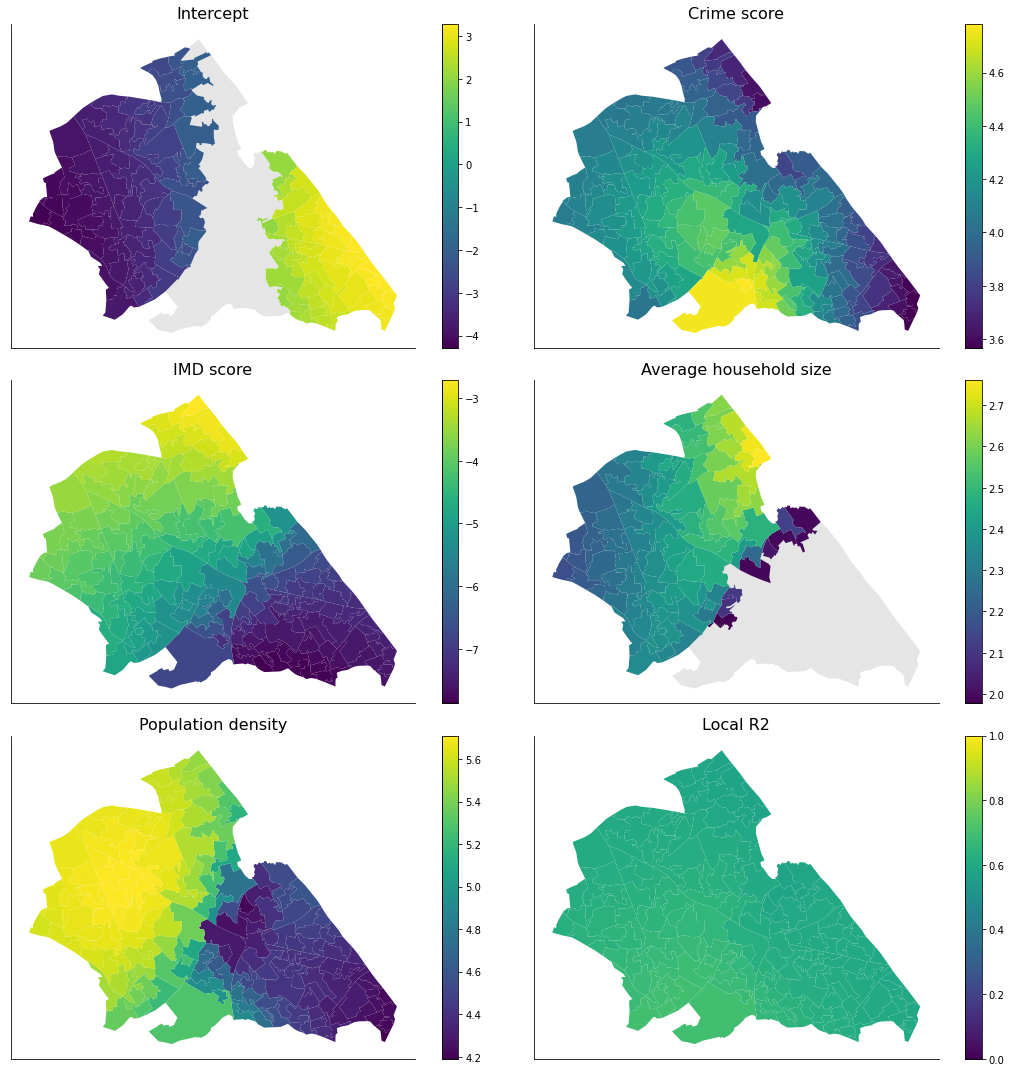

In [431]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(3,2,figsize=(15,15), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','Crime score', 'IMD score','Average household size', 'Population density']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    brent_temp = brent_shp.assign(toplot=filtered_estimates.T[i])
    (brent_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (brent_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

 
# For the last one, local R2, we can just map all of them regarding the significance

(brent_shp.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
sns.despine()    
plt.show()